In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

## transfrorm data and put it in data loader

In [2]:
transformtion = transforms.Compose([
                                    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
train_data = datasets.CIFAR10(root='data',train=True,download=True,transform=transformtion)
test_data = datasets.CIFAR10(root='data',train=False,download=True,transform=transformtion)

100%|██████████| 170498071/170498071 [00:02<00:00, 62291092.54it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [4]:
train_loader = DataLoader(train_data,batch_size=32,shuffle=True)
test_loader = DataLoader(test_data,batch_size=32,shuffle=False)


In [5]:
print(f"Train batch size: {len(train_loader)}")
print(f"Test batch size: {len(test_loader)}")

Train batch size: 1563
Test batch size: 313


In [6]:
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## visualize sample of the data

Text(0.5, 1.0, 'frog')

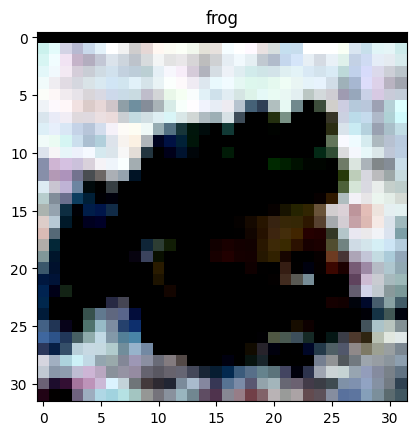

In [7]:
image,label = test_data[0]
image
torch.manual_seed(19)
train_loader_feature , label_loader_featuer = next(iter(train_loader))
plt.imshow(np.transpose(train_loader_feature[0].numpy(), (1, 2, 0)) ,cmap='gray')
plt.title(class_names[label_loader_featuer[0]])

In [8]:
train_loader_feature[0].shape

torch.Size([3, 32, 32])

## build CNN simple model

In [9]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(nn.Conv2d(3,200,3),
                           nn.ReLU(),
                           nn.Conv2d(200,250,3),
                           nn.ReLU(),
                           nn.MaxPool2d(2))

    self.layer2 = nn.Sequential(nn.Conv2d(250,350,3),
                           nn.ReLU(),
                           nn.Conv2d(350,450,3),
                           nn.ReLU(),
                           nn.MaxPool2d(2))

    self.layer3 = nn.Sequential(nn.Flatten(),
                                nn.Linear(450,10)
                          )
  def forward(self,x):
    x = self.layer1(x)
   # print(x.shape)
    x = self.layer2(x)
   # print(x.shape)
    x = self.layer3(x)
   # print(x.shape)
    return x


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## using resnet modle

In [11]:
torch.manual_seed(42)
model = torchvision.models.resnet18()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
!pip install torchinfo

## display some info of the modle

In [13]:
import torchinfo
torchinfo.summary(model,[32,3,32,32])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 16, 16]          9,408
├─BatchNorm2d: 1-2                       [32, 64, 16, 16]          128
├─ReLU: 1-3                              [32, 64, 16, 16]          --
├─MaxPool2d: 1-4                         [32, 64, 8, 8]            --
├─Sequential: 1-5                        [32, 64, 8, 8]            --
│    └─BasicBlock: 2-1                   [32, 64, 8, 8]            --
│    │    └─Conv2d: 3-1                  [32, 64, 8, 8]            36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 8, 8]            128
│    │    └─ReLU: 3-3                    [32, 64, 8, 8]            --
│    │    └─Conv2d: 3-4                  [32, 64, 8, 8]            36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 8, 8]            128
│    │    └─ReLU: 3-6                    [32, 64, 8, 8]            --
│

## define loss and optmizer and start training and evaluation the model

In [14]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.1)
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch./eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [15]:
num_epochs = 150
loss_train,loss_test = [],[]
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    test_loss,running_loss = 0.0,0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        #print(inputs.shape)  # Zero the parameter gradients

        # Forward pass
        outputs = model(inputs.to(device))
       # print(labels.shape)
        lossfun = loss(outputs, labels.to(device))
        # Backward pass and optimize
        lossfun.backward()
        optimizer.step()

        # Print statistics
        running_loss += lossfun.item()
    print(f"Epoch {epoch+1}, Training Loss: {running_loss/len(train_loader)}")
    loss_train.append(running_loss/len(train_loader))

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.to(device))
            _, predicted = torch.max(outputs, 1)
            lossfun = loss(outputs, labels.to(device))
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
            test_loss += lossfun.item()
        loss_test.append(test_loss/len(test_loader))


    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Validation Accuracy: {accuracy:.2f}%")

Epoch 1, Training Loss: 1.8018117084460463
Epoch 1, Validation Accuracy: 45.11%
Epoch 2, Training Loss: 1.3297185553088833
Epoch 2, Validation Accuracy: 44.51%
Epoch 3, Training Loss: 1.152224337719071
Epoch 3, Validation Accuracy: 60.42%
Epoch 4, Training Loss: 1.0240749411489898
Epoch 4, Validation Accuracy: 60.09%
Epoch 5, Training Loss: 0.9370386546152338
Epoch 5, Validation Accuracy: 66.55%
Epoch 6, Training Loss: 0.8694150439837157
Epoch 6, Validation Accuracy: 65.39%
Epoch 7, Training Loss: 0.8163271158914572
Epoch 7, Validation Accuracy: 71.01%
Epoch 8, Training Loss: 0.7765829238137296
Epoch 8, Validation Accuracy: 70.62%
Epoch 9, Training Loss: 0.7424126035001746
Epoch 9, Validation Accuracy: 72.63%
Epoch 10, Training Loss: 0.7071934400921209
Epoch 10, Validation Accuracy: 73.75%
Epoch 11, Training Loss: 0.6804652375169694
Epoch 11, Validation Accuracy: 72.92%
Epoch 12, Training Loss: 0.651016911767037
Epoch 12, Validation Accuracy: 73.97%
Epoch 13, Training Loss: 0.624584301

In [18]:
len(loss_test)
epochs = [*range(1,101,1)]
len(epochs)

100

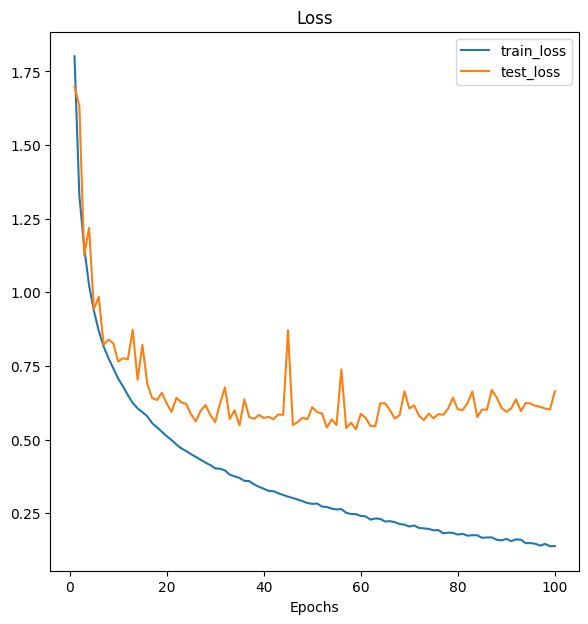

In [19]:
plt.figure(figsize=(15, 7))
    # Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_train, label='train_loss')
plt.plot(epochs, loss_test, label='test_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy

## make some prediction


In [62]:
transtorm =transforms.Compose([
                                    transforms.Resize((32,32)),
                                    transforms.RandomCrop(32, padding=4),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Compose(
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
    RandomCrop(size=(32, 32), padding=4)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [41]:
import os
test_paths ='/kaggle/input/test-images1'
os.listdir(test_paths)

['horse.jpg', 'cat.jpg', 'bird.jpg', 'frog.jpg']

In [46]:
dirs =[]
test_images = []
for img in os.listdir(test_paths):
    get_path = os.path.join(test_paths,img)
    dirs.append(get_path)
    image = torchvision.io.read_image(get_path)
    test_images.append(image)
    
dirs
test_images[0].shape

torch.Size([3, 360, 540])

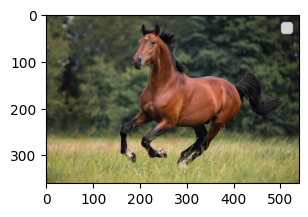

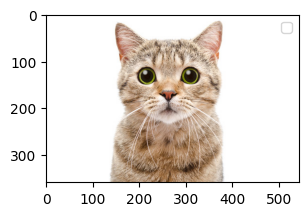

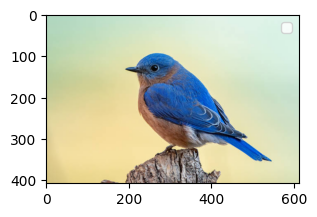

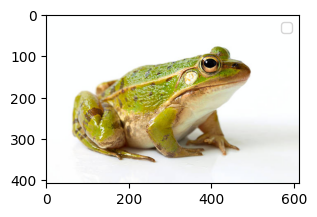

In [48]:
for i in test_images:
    plt.figure(figsize=(15, 7))
    # Plot loss
    plt.subplot(1, 4, 1)
    plt.imshow(i.permute(1,2,0))
    plt.legend()


    

In [57]:
transformed_images =[] 
for i in test_images:
    pil_image = transforms.ToPILImage()(i)
    transformed_image = transtorm(pil_image)
    transformed_images.append(transformed_image)
len(transformed_images)

4

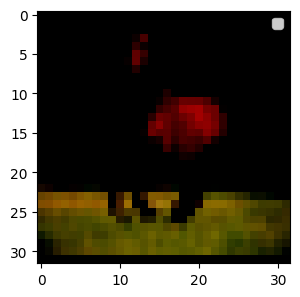

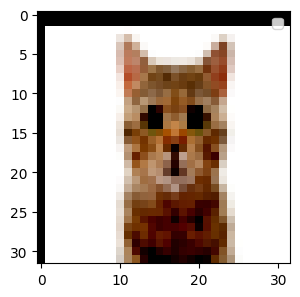

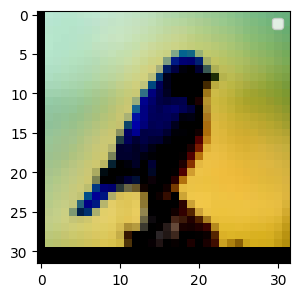

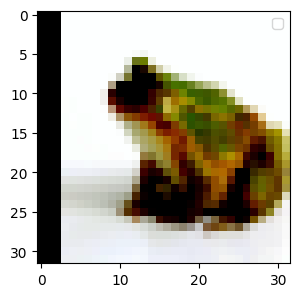

In [63]:
for i in transformed_images:
    plt.figure(figsize=(15, 7))
    # Plot loss
    plt.subplot(1, 4, 1)
    plt.imshow(i.permute(1,2,0))
    plt.legend()
    

In [59]:
test_predictions =[]
for image in transformed_images:
    image_pred = model(image.unsqueeze(dim=0).to(device))
    custom_image_pred_label = torch.argmax(image_pred, dim=1)
    test_predictions.append(class_names[custom_image_pred_label.cpu()])



In [61]:
print("actuall classes is:")
print(os.listdir(test_paths))
print("predicted class is: ")
print(test_predictions)

actuall classes is:
['horse.jpg', 'cat.jpg', 'bird.jpg', 'frog.jpg']
predicted class is: 
['horse', 'cat', 'bird', 'frog']
